<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/main/AML_IceCores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! gdown --id 1FkB-wMHYzgK74-pek2H33DIpmfSOIxWc
! unzip Insoluables_TrainingData26May2022.zip
! unzip Peru_data.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: images/QCY/QCY_27_2_5_270.png  
 extracting: images/QCY/QCY_27_2_5_271.png  
 extracting: images/QCY/QCY_27_2_5_272.png  
 extracting: images/QCY/QCY_27_2_5_273.png  
 extracting: images/QCY/QCY_27_2_5_274.png  
  inflating: images/QCY/QCY_27_2_5_275.png  
  inflating: images/QCY/QCY_27_2_5_276.png  
  inflating: images/QCY/QCY_27_2_5_277.png  
 extracting: images/QCY/QCY_27_2_5_278.png  
 extracting: images/QCY/QCY_27_2_5_279.png  
  inflating: images/QCY/QCY_27_2_5_28.png  
 extracting: images/QCY/QCY_27_2_5_280.png  
 extracting: images/QCY/QCY_27_2_5_281.png  
  inflating: images/QCY/QCY_27_2_5_282.png  
  inflating: images/QCY/QCY_27_2_5_283.png  
 extracting: images/QCY/QCY_27_2_5_284.png  
 extracting: images/QCY/QCY_27_2_5_285.png  
  inflating: images/QCY/QCY_27_2_5_286.png  
 extracting: images/QCY/QCY_27_2_5_287.png  
 extracting: images/QCY/QCY_27_2_5_288.png  
 extracting: images/QCY/QCY_27_2_5_289.png  
 extr

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb

In [3]:
peru_path = '/content/QCY.csv'
peru_im_path = '/content/images/QCY/'
peru_df = pd.read_csv(peru_path)
peru = not_training_set(peru_df, peru_im_path)

In [21]:
im, feat = peru.__getitem__(10)

In [4]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [19]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [ ]:
x_train.shape

(10000, 128, 128)

In [ ]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_10 (Dense)            (None, 64)                3936320   
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 dense_11 (Dense)            (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 10s 34ms/step - loss: 0.0356 - val_loss: 0.0124
Epoch 2/200
282/282 [==============================] - 10s 34ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 3/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 4/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 5/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 8/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0

In [ ]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [ ]:
y_preds = encoder.predict(x_train)

In [ ]:
map = umap.UMAP(n_components=2)
y = map.fit_transform(y_preds)

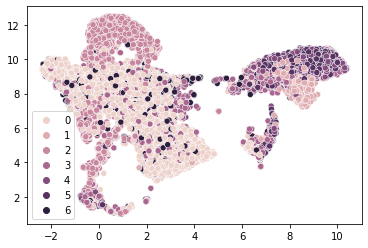

In [ ]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [ ]:
input_length = len(x_train_feats[0]) + latent_dim

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

dense_model = keras.Model(dense_input, dense_output, name='dense_model')

dense_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

dense_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_12 (Dense)            (None, 128)               12672     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  dense_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 3s 6ms/step - loss: 0.9731 - accuracy: 0.6734 - val_loss: 0.6064 - val_accuracy: 0.7940
Epoch 2/200
282/282 [==============================] - 1s 5ms/step - loss: 0.6959 - accuracy: 0.7560 - val_loss: 0.5610 - val_accuracy: 0.8020
Epoch 3/200
282/282 [==============================] - 1s 5ms/step - loss: 0.6391 - accuracy: 0.7696 - val_loss: 0.5465 - val_accuracy: 0.8020
Epoch 4/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5712 - accuracy: 0.7940 - val_loss: 0.5451 - val_accuracy: 0.8100
Epoch 5/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5629 - accuracy: 0.7934 - val_loss: 0.5207 - val_accuracy: 0.8130
Epoch 6/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5323 - accuracy: 0.8068 - val_loss: 0.5136 - val_accuracy: 0.8130
Epoch 7/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5180 - accuracy: 0.8109 - val_loss: 0.5099 - val_accuracy: 0.8160

In [ ]:
dense_model.save('dense_model')

INFO:tensorflow:Assets written to: dense_model/assets


In [ ]:
tree = lgb.LGBMClassifier(objective='multiclass')

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
y_pred = tree.predict(x_train_with_encoded)

In [ ]:
sum(y_pred==x_train_lab)/len(y_pred)

0.8694